In [1]:
import os
import glob
import json
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from pycocotools.coco import COCO
from pycocotools.mask import decode
from tensorflow import keras
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import io as tf_io
import requests


In [20]:
# Paths
train_dir = r"D:\wallpapers and photos\saran da\brain tumer\train"
test_dir=r"D:\wallpapers and photos\saran da\brain tumer\test"
val_dir=r"D:\wallpapers and photos\saran da\brain tumer\valid"
annotation_train = r"D:\wallpapers and photos\saran da\brain tumer\train\_annotations.coco.json" 
annotation_test=r"D:\wallpapers and photos\saran da\brain tumer\test\_annotations.coco.json"
annotation_val=r"D:\wallpapers and photos\saran da\brain tumer\valid\_annotations.coco.json"
img_size = 256
batch_size = 32

In [21]:
train_coco=COCO(annotation_train)
test_coco=COCO(annotation_test)
val_coco=COCO(annotation_val)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [22]:
def load_image_and_mask(coco, image_dir, image_id):
    image_info = coco.loadImgs(image_id)[0]
    image_path = os.path.join(image_dir, image_info['file_name'])
    image = Image.open(image_path)
    image = np.array(image)

    ann_ids = coco.getAnnIds(imgIds=image_id)
    anns = coco.loadAnns(ann_ids)
    mask = np.zeros((image_info['height'], image_info['width']))
    for ann in anns:
        mask = np.maximum(mask, coco.annToMask(ann))

    return image, mask
def create_tf_dataset(coco, image_dir, image_ids):
    def generator():
        for image_id in image_ids:
            yield load_image_and_mask(coco, image_dir, image_id)

    return tf.data.Dataset.from_generator(generator,
                                          output_signature=(tf.TensorSpec(shape=(None, None, 3), dtype=tf.uint8), 
                                                            tf.TensorSpec(shape=(None, None), dtype=tf.uint8)))


In [23]:
train_dataset=create_tf_dataset(train_coco,train_dir,train_coco.getImgIds())
test_dataset=create_tf_dataset(test_coco,test_dir,train_coco.getImgIds())
val_dataset=create_tf_dataset(val_coco,val_dir,train_coco.getImgIds())

In [24]:
def preprocess(image, mask):
    
    image = tf.image.resize(image, (img_size,img_size))
    
    mask = tf.expand_dims(mask, axis=-1)  
    mask = tf.image.resize(mask, (img_size,img_size))
 
    image = tf.cast(image, tf.float32) / 255.0
    
    return image, mask

In [25]:
train_dataset=train_dataset.map(preprocess)
test_dataset=test_dataset.map(preprocess)
val_dataset=val_dataset.map(preprocess)

In [26]:
def visualize_dataset(dataset, num_samples=5):
    for i, (image, mask) in enumerate(dataset.take(num_samples)):
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(image.numpy())
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(mask.numpy().squeeze(), cmap="gray")
        plt.title("Mask")
        plt.axis("off")

        plt.show()


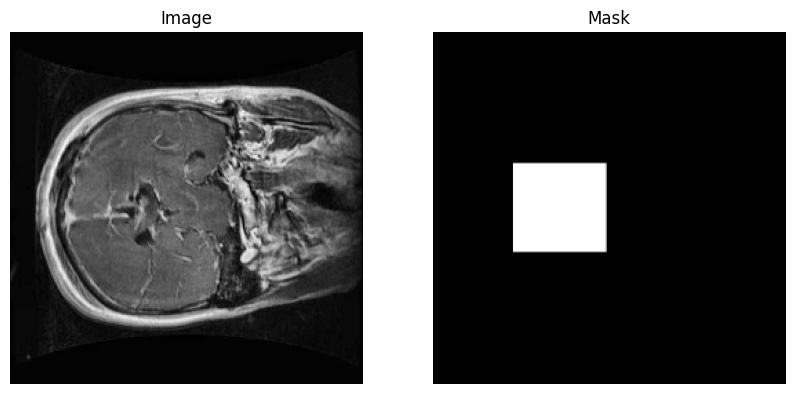

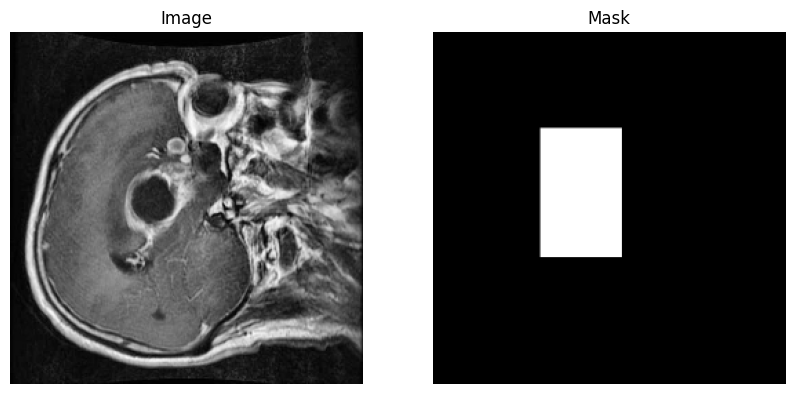

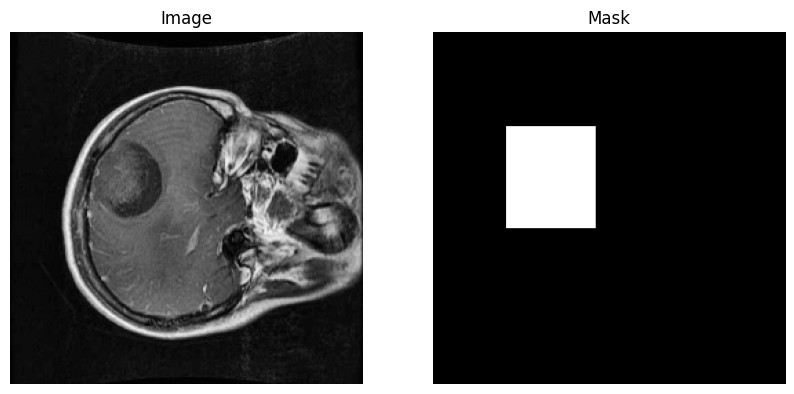

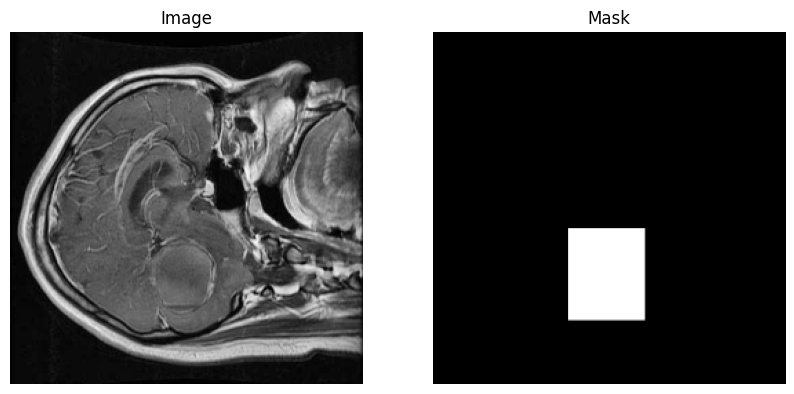

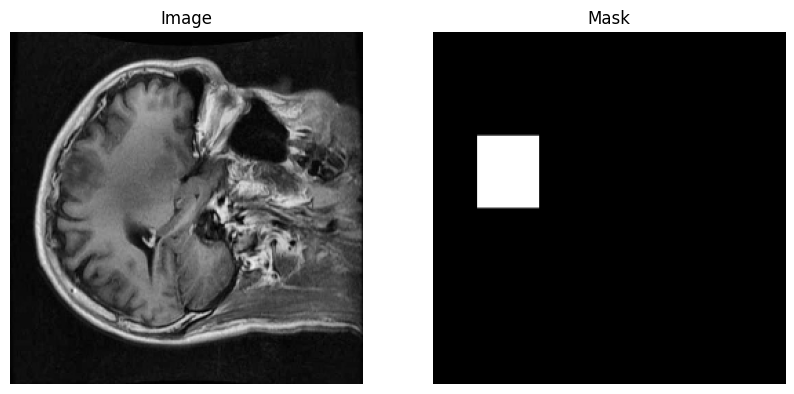

In [27]:
visualize_dataset(train_dataset)

In [28]:
'''After visulization we can batch our dataset'''
Batch=4
Autotune=tf.data.AUTOTUNE
train_dataset=train_dataset.repeat().batch(batch_size=Batch).prefetch(buffer_size=Autotune)
test_dataset=test_dataset.repeat().batch(batch_size=Batch).prefetch(buffer_size=Autotune)
val_dataset=val_dataset.repeat().batch(batch_size=Batch).prefetch(buffer_size=Autotune)

In [29]:
steps_per_epoch = len(train_coco.getImgIds()) // Batch
validation_steps = len(val_coco.getImgIds()) // Batch
test_steps = len(test_coco.getImgIds()) // Batch

In [30]:
steps_per_epoch

375

In [31]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def convolution_block(block_input, num_filters=256, kernel_size=3, dilation_rate=1, use_bias=False):
    x = layers.Conv2D(num_filters, kernel_size=kernel_size, dilation_rate=dilation_rate, padding="same",
                      use_bias=use_bias, kernel_initializer=keras.initializers.HeNormal())(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)

def DilatedSpatialPyramidPooling(dspp_input):
    dim = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dim[-3], dim[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=False)
    out_pool = layers.UpSampling2D(size=(dim[-3] // x.shape[1], dim[-2] // x.shape[2]), interpolation="bilinear")(x)
    
    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.concatenate([out_pool, out_1, out_6, out_12, out_18], axis=-1)
    output = convolution_block(x, kernel_size=1)
    return output

def DeeplabV3Plus(img_size, num_classes):
    model_input = keras.Input(shape=(img_size, img_size, 3))

    # Load the ResNet50 model
    preprocessed = keras.applications.resnet50.preprocess_input(model_input)
    resnet50 = keras.applications.ResNet50(weights="imagenet", include_top=False, input_tensor=preprocessed)
    
    x = resnet50.get_layer("conv4_block6_2_relu").output  # Ensure this layer exists
    x = DilatedSpatialPyramidPooling(x)

    # Upsampling calculations
    height_factor = img_size // 4 // x.shape[1]
    width_factor = img_size // 4 // x.shape[2]

    input_a = layers.UpSampling2D(size=(height_factor, width_factor), interpolation="bilinear")(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)

    # Final upsampling
    x = layers.UpSampling2D(size=(img_size // x.shape[1], img_size // x.shape[2]), interpolation="bilinear")(x)
    model_output = layers.Conv2D(1, kernel_size=(1, 1), padding="same")(x)

    return keras.Model(inputs=model_input, outputs=model_output)

# Define model
img_size = 256
num_classes = 1
model = DeeplabV3Plus(img_size=img_size, num_classes=num_classes)
model.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.__operators__.getitem_4 (Sl  (None, 256, 256, 3)  0          ['input_5[0][0]']                
 icingOpLambda)                                                                                   
                                                                                                  
 tf.nn.bias_add_4 (TFOpLambda)  (None, 256, 256, 3)  0           ['tf.__operators__.getitem_4[0][0
                                                                 ]']                        

In [32]:
loss = keras.losses.BinaryCrossentropy(from_logits=True)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=loss,
    metrics=["accuracy"]
)

early=keras.callbacks.EarlyStopping(patience=5)
check=keras.callbacks.ModelCheckpoint("Tumor.keras",save_best_only=True)

history = model.fit(train_dataset, validation_data=val_dataset, steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,epochs=10,callbacks=[early,check])


Epoch 1/10
375/375 [==============================] - 84s 200ms/step - loss: 0.1314 - accuracy: 0.9620 - val_loss: 0.1668 - val_accuracy: 0.9625
Epoch 2/10
375/375 [==============================] - 74s 198ms/step - loss: 0.0614 - accuracy: 0.9778 - val_loss: 1.3037 - val_accuracy: 0.9625
Epoch 3/10
375/375 [==============================] - 75s 200ms/step - loss: 0.0465 - accuracy: 0.9822 - val_loss: 0.1618 - val_accuracy: 0.9625
Epoch 4/10
375/375 [==============================] - 75s 200ms/step - loss: 0.0363 - accuracy: 0.9854 - val_loss: 0.1460 - val_accuracy: 0.9625
Epoch 5/10
375/375 [==============================] - 75s 200ms/step - loss: 0.0320 - accuracy: 0.9867 - val_loss: 0.1360 - val_accuracy: 0.9625
Epoch 6/10
375/375 [==============================] - 75s 199ms/step - loss: 0.0259 - accuracy: 0.9889 - val_loss: 0.1479 - val_accuracy: 0.9625
Epoch 7/10
375/375 [==============================] - 75s 199ms/step - loss: 0.0230 - accuracy: 0.9898 - val_loss: 0.1921 - val_ac

In [51]:
#model.save("tumor.h5")
tumor_model=keras.models.load_model("tumor.h5")

In [54]:
import random
import tensorflow as tf
import matplotlib.pyplot as plt

def visualize_predictions(model, dataset, num_samples=5, threshold=0.5):
    # Extract a batch from dataset
    for images, masks in dataset.take(2):  # Take a single batch
        images_np = images.numpy()  # Convert to NumPy
        masks_np = masks.numpy()  # Convert masks to NumPy
    
    # Make predictions
    predictions = model.predict(images_np)
    binary_predictions = (predictions > threshold).astype('uint8')

    # Select random samples from the batch
    indices = random.sample(range(len(images_np)), min(num_samples, len(images_np)))

    for i in indices:
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(images_np[i])
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(masks_np[i].squeeze(), cmap='gray')
        plt.title('True Mask')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(binary_predictions[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

        plt.show()


1/1 [==============================] - 0s 28ms/step


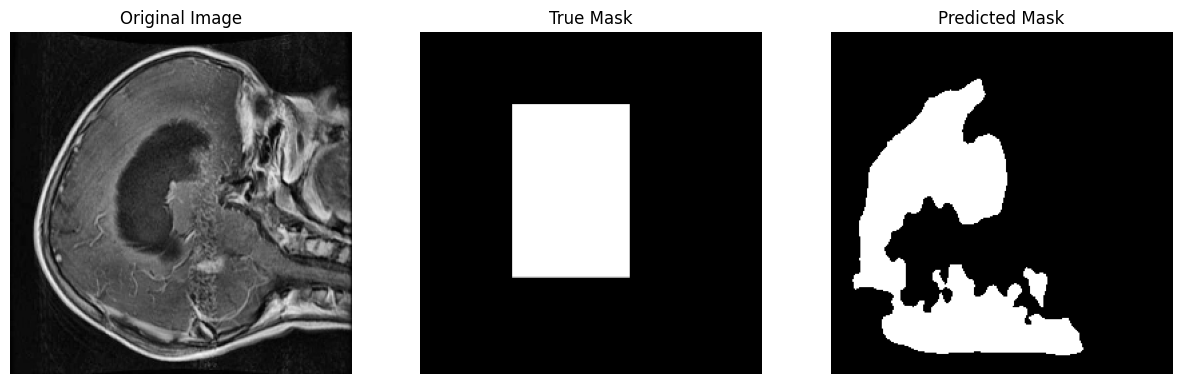

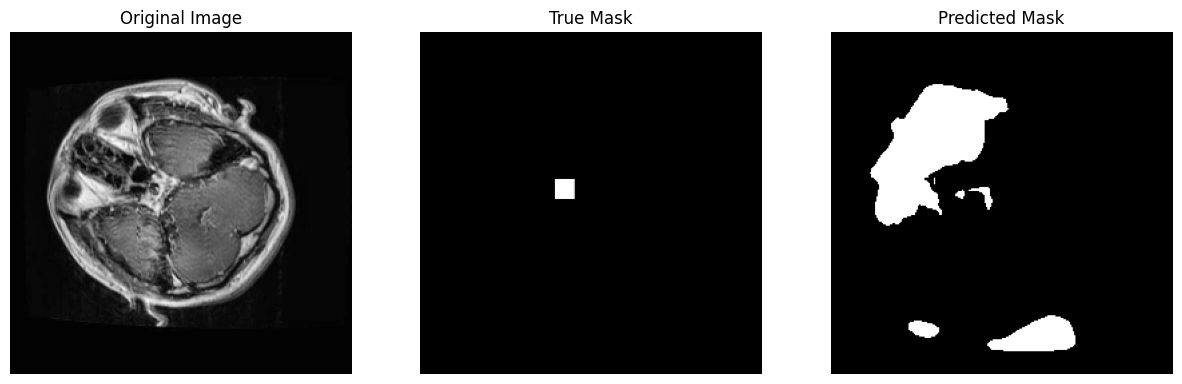

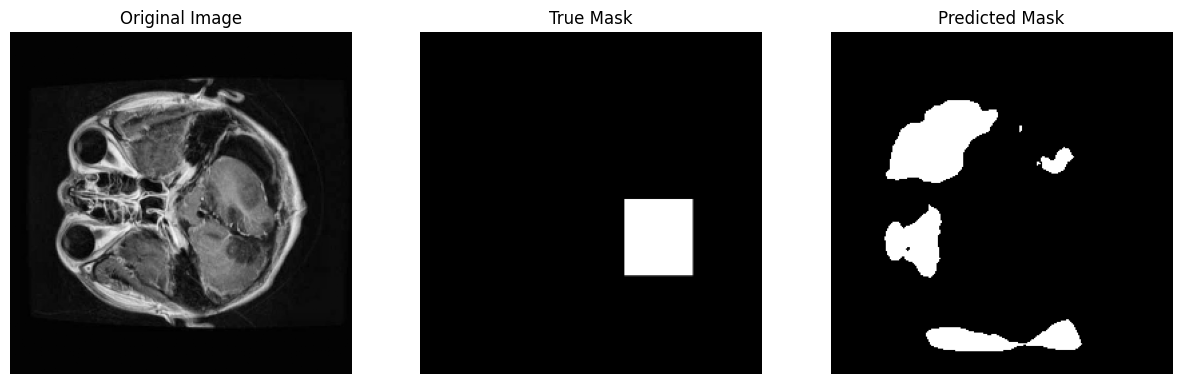

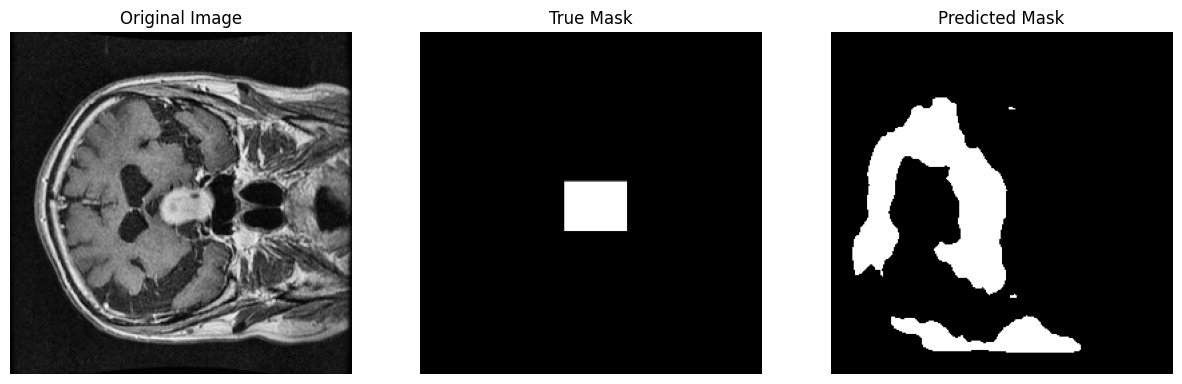

In [55]:
visualize_predictions(tumor_model,test_dataset)